## Bell, T1, T2 Parallel Experiment
This is an experiment to Run T1/T2 Experiment device-wide, and also to run parallel Bell state measurements as a simple proxy for two-qubit gate fidelity. Note this measure of Hellinger fidelity from the Bell test is sensitive to state preparation and measurement (SPAM) error as well. This particular test repeats the CX gate several times (see code, default is 5).

In [105]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import rustworkx as rx
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_device_benchmarking

#preferred that the qiskit_device_benchmark package is installed as 'pip install .' but if not
#uncomment the following
#import sys 
#sys.path.append('../')

#import paths_flatten,remove_permutations,path_to_edges,build_sys_graph,get_separated_sets
import qiskit_device_benchmarking.utilities.graph_utils  as gu

#for testing
from qiskit_aer import AerSimulator

#import the qiskit experiment modules
#uses Tphi experiment
from qiskit_experiments.library import Tphi
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment

#import the custom bell experiment
from qiskit_device_benchmarking.bench_code.bell.bell_experiment import BellExperiment

In [8]:
#enter your device hub/group/project here
#and device
hgp = 'ibm-q/open/main'
  
service = QiskitRuntimeService()
backend_real=service.backend('ibm_kyiv',instance=hgp)
nq = backend_real.configuration().n_qubits
coupling_map = backend_real.configuration().coupling_map

#if you want to use the simulator 
#uncomment
if (0):
    backend_sim = AerSimulator.from_backend(backend)
    backend = backend_sim
else:
    backend = backend_real

In [3]:
#build a set of gates
G = gu.build_sys_graph(nq, coupling_map)
#get all length 2 paths in the device
paths = rx.all_pairs_all_simple_paths(G,2,2)
#flatten those paths into a list from the rustwork x iterator
paths = gu.paths_flatten(paths)
#remove permutations
paths = gu.remove_permutations(paths)
#convert to the coupling map of the device
paths = gu.path_to_edges(paths,coupling_map)
#make into separate sets
sep_sets = gu.get_separated_sets(G, paths, min_sep=2)

qubits_nns = gu.get_iso_qubit_list(G)

In [90]:
# Time intervals to wait before measurement for t1 and t2
delays_t1 = [0] + np.arange(1e-6, 100e-6, 10e-6).tolist() + np.arange(130e-6, 300e-6, 40e-6).tolist()
delays_t2 = [0] + np.arange(1e-6, 100e-6, 10e-6).tolist() + np.arange(130e-6, 300e-6, 40e-6).tolist()
num_periods = 5
max_T = delays_t2[-1]
osc_freq = num_periods/(max_T)

In [92]:
#Construct the experiments

#First the Tphi
exp_batches = []
for qubits in qubits_nns:
    coh_exps = ParallelExperiment([
        Tphi((int(qubit),), delays_t1=delays_t1,delays_t2=delays_t2,t2type='hahn',osc_freq=osc_freq,backend=backend)
        for qubit in np.array(qubits).flatten()], flatten_results=False)
    exp_batches.append(coh_exps)

#Bell
bell_exp = BellExperiment(sep_sets,backend=backend)
exp_batches.append(bell_exp)

#Batch all together
batch_exp = BatchExperiment(exp_batches,backend=backend,flatten_results=False)

In [173]:
%%time
#Run
batch_exp.set_run_options(shots=300)
batch_exp_data = batch_exp.run()

CPU times: user 54.5 s, sys: 417 ms, total: 54.9 s
Wall time: 1min


In [175]:
batch_exp_data.status()

<ExperimentStatus.POST_PROCESSING: 'experiment analysis is actively running'>

## Analyze Tphi data

Plotting Q0


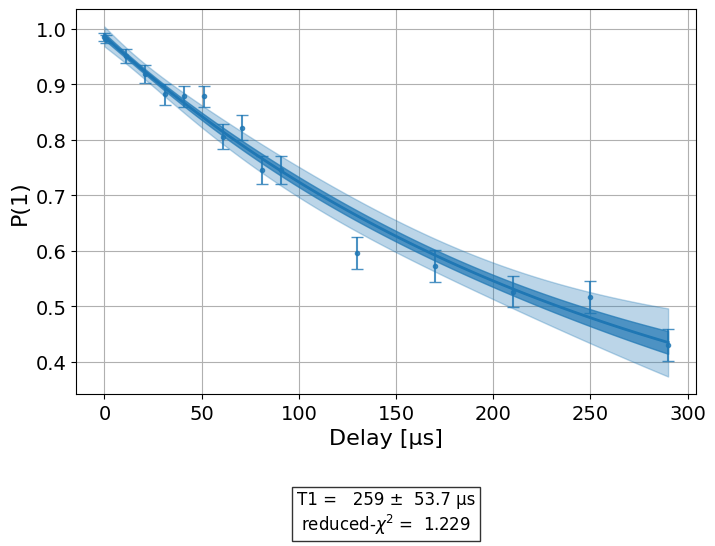

In [172]:
plot_q = 0
#0 for the T1, 1 for the T2
plot_type = 0
plot_ind = []
for i in range(len(qubits_nns)):
    for j in range(len(qubits_nns[i])):
        if plot_q==qubits_nns[i][j]:
            plot_ind = [i,j]
            break

print('Plotting Q%d'%plot_q)
batch_exp_data.child_data()[i].child_data()[j].figure(plot_type)

In [97]:
#generate a T1/T2 list
q_list = []
t1_list = []
t2_list = []
for i in range(len(qubits_nns)):
    data1 = batch_exp_data.child_data()[i]
    for j in range(len(qubits_nns[i])):
        q_list.append(qubits_nns[i][j])
        t1_list.append(data1.child_data()[j].analysis_results()[2].value.nominal_value)
        t2_list.append(data1.child_data()[j].analysis_results()[4].value.nominal_value)


Text(0.5, 1.0, 'Device Coherence for ibm_kyiv, job csdas7wtj7dg008cfjgg')

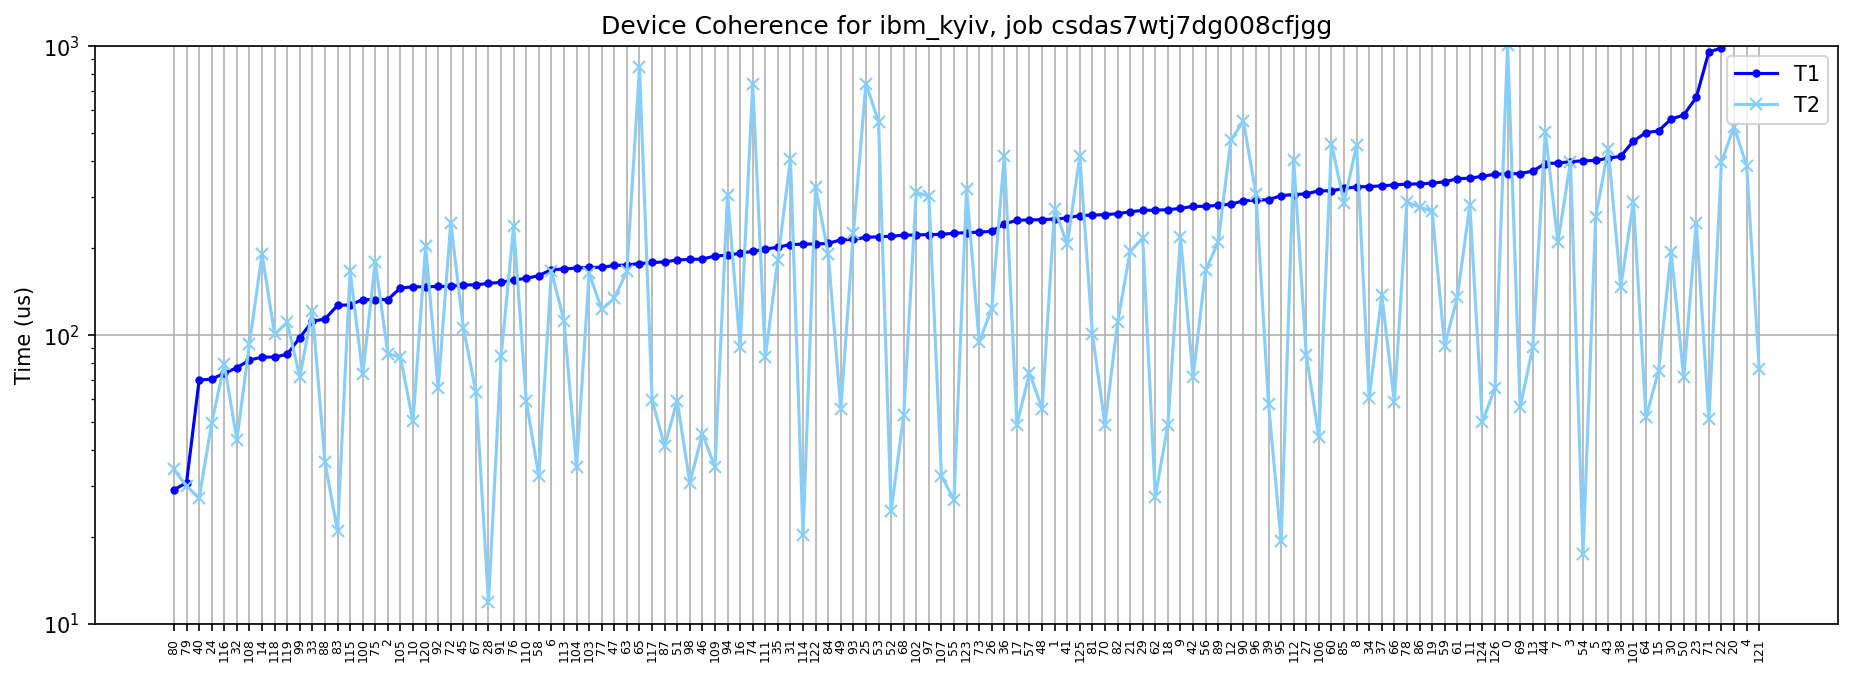

In [112]:
#plot the data ordered by Bell state fidelity (need to run the cell above first)

plt.figure(dpi=150,figsize=[15,5])
argind = np.argsort(t1_list)
plt.semilogy(range(len(q_list)),np.array(t1_list)[argind]/1e-6,label='T1', marker='.',color='blue')
plt.semilogy(range(len(q_list)),np.array(t2_list)[argind]/1e-6,label='T2', marker='x',color='lightskyblue')

plt.xticks(range(len(q_list)),np.array(q_list)[argind],rotation=90,fontsize=6);
plt.ylabel('Time (us)')
plt.ylim([10,1000])
plt.grid(True)
plt.legend()
plt.title('Device Coherence for %s, job %s'%(backend_real.name, batch_exp_data.job_ids[0]))

Text(0.5, 1.0, 'Device Coherence for ibm_kyiv, job csdas7wtj7dg008cfjgg')

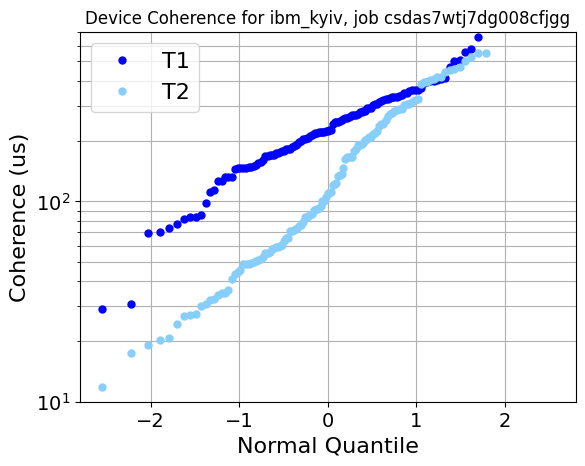

In [111]:
#Quantile plot
plt.figure(dpi=100)
x1 = stats.probplot(t1_list)
x2 = stats.probplot(t2_list)

plt.semilogy(x1[0][0],x1[0][1]/1e-6,linestyle='None',marker='.',markersize=10,label='T1',color='blue')
plt.semilogy(x2[0][0],x2[0][1]/1e-6,linestyle='None',marker='.',markersize=10,label='T2',color='lightskyblue')

plt.grid(True,which='both')
plt.legend(fontsize=16)
plt.xlabel('Normal Quantile',fontsize=16)
plt.ylabel('Coherence (us)',fontsize=16)
plt.ylim([10,700])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Device Coherence for %s, job %s'%(backend_real.name, batch_exp_data.job_ids[0]))

## Analyze Bell

In [223]:
#Pull the data from the dataframe
df = batch_exp_data.child_data()[2].analysis_results()[0].value
bell_edge_list = []
bell_fid_list = []
for i in df.iterrows():
    bell_edge_list.append(i[1]['connection'])
    bell_fid_list.append(i[1]['fidelity'])


Text(0.5, 1.0, 'Bell Edges for ibm_kyiv, job csdb9getj7dg008cfm00')

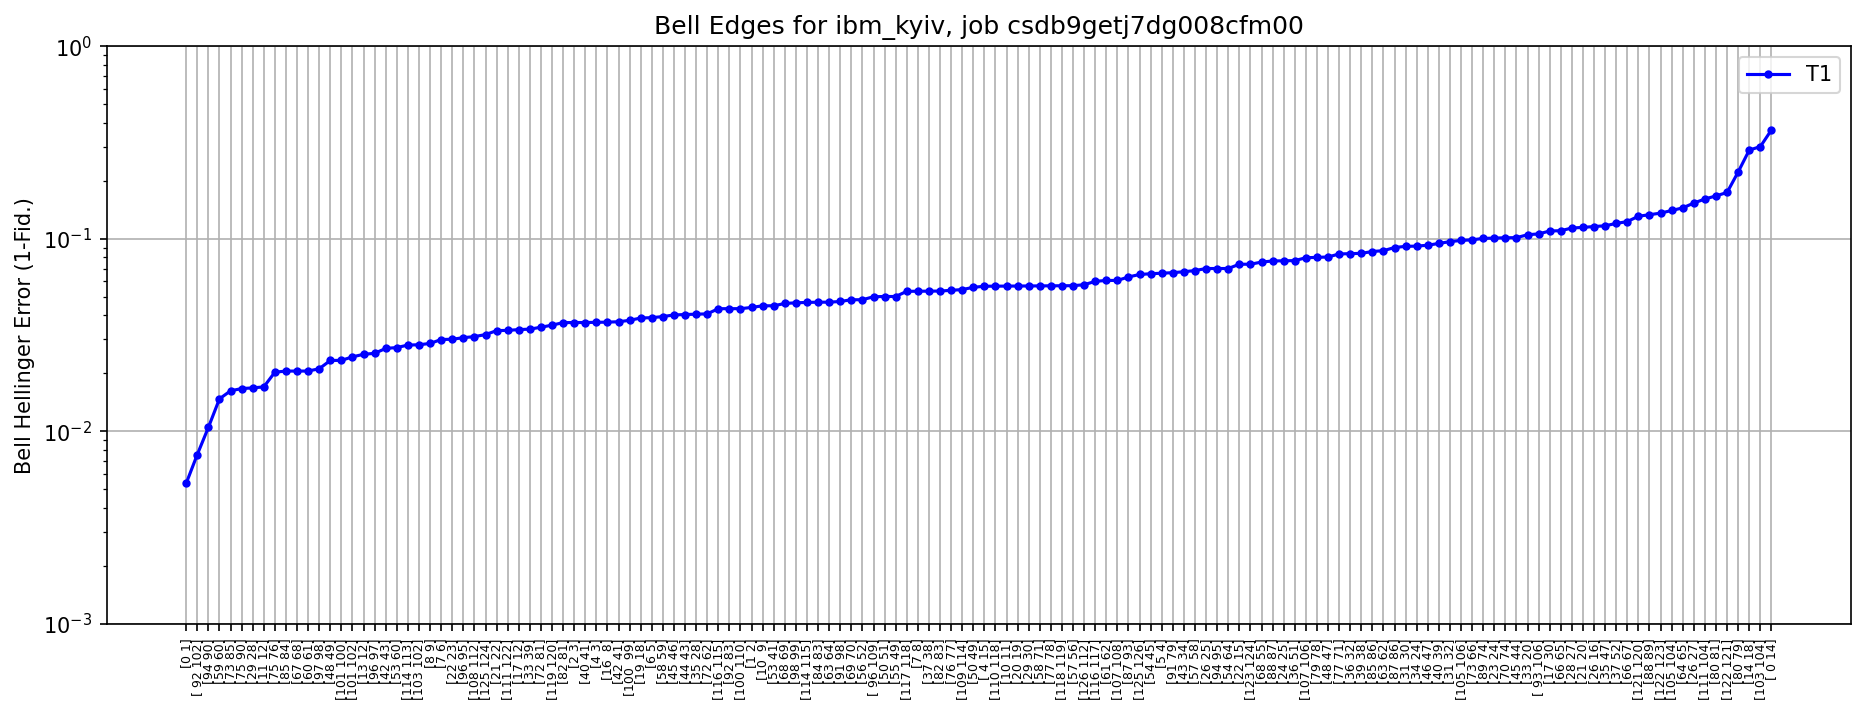

In [234]:
#plot the data ordered by Bell state fidelity (need to run the cell above first)

plt.figure(dpi=150,figsize=[15,5])
argind = np.argsort(1-np.array(bell_fid_list))
plt.semilogy(range(len(bell_edge_list)),1-np.array(bell_fid_list)[argind],label='T1', color='blue', marker='.')

plt.xticks(range(len(bell_edge_list)),np.array(bell_edge_list)[argind],rotation=90,fontsize=6);
plt.ylabel('Bell Hellinger Error (1-Fid.)')
plt.ylim([1e-3,1])
plt.grid(True)
plt.legend()
plt.title('Bell Edges for %s, job %s'%(backend_real.name, batch_exp_data.job_ids[0]))

In [1]:
from IPython.display import HTML, display
import datetime
def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))

qiskit_copyright()